In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit import transpile
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.circuit.library import ZZFeatureMap
from qiskit.visualization import plot_histogram

     ┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1 
Measurement results: {'00': 499, '11': 525}


c:\Users\Akram\anaconda3\envs\qiskit_env\Lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:975: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


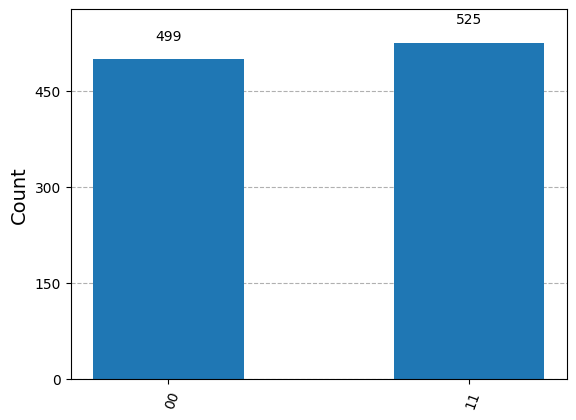

In [10]:
# Create a quantum circuit with 2 qubits and 2 classical bits
qc = QuantumCircuit(2, 2)

# Apply a Hadamard gate to the first qubit
qc.h(0)

# Apply a CNOT gate with qubit 0 as control and qubit 1 as target
qc.cx(0, 1)

# Measure both qubits
qc.measure([0, 1], [0, 1])

# Print the circuit
print(qc.draw())

# Create a GenericBackendV2 with 2 qubits
backend = GenericBackendV2(num_qubits=2)

# Transpile the circuit for the backend
tqc = transpile(qc, backend)

# Run the circuit on the fake backend
job = backend.run(tqc, shots=1024)

# Get the result
result = job.result()

# Get the counts (measurement results)
counts = result.get_counts()

# Print the measurement results
print("Measurement results:", counts)

# Plot the results
plot_histogram(counts)
# plt.show()

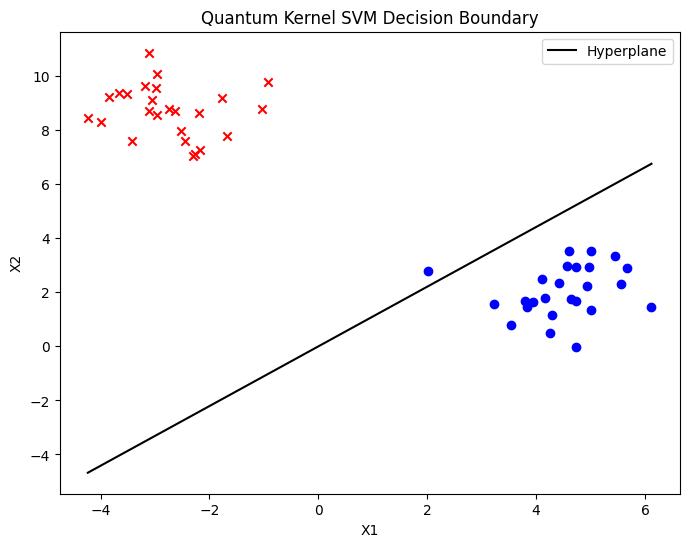

Optimal alphas: [1.00000000e+00 1.00000000e+00 0.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 6.31334604e-01 1.00000000e+00 1.00000000e+00
 8.30773475e-01 1.00000000e+00 0.00000000e+00 1.00000000e+00
 1.00000000e+00 6.40965063e-01 1.00000000e+00 2.16455458e-01
 0.00000000e+00 1.00000000e+00 1.00000000e+00 2.31612538e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 9.30601827e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 9.01653198e-01
 6.20161684e-01 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 9.51606563e-01 0.00000000e+00 1.00000000e+00
 0.00000000e+00 2.77555756e-17 1.00000000e+00 1.00000000e+00
 0.00000000e+00 1.00000000e+00]
Bias term: -0.0392241503870116
Weight vector approximation: [ 133.15192104 -120.55715565]


In [ ]:
# Generate synthetic linearly separable data
X, y = make_blobs(n_samples=50, centers=2, n_features=2, random_state=42)

# Convert labels from {0,1} to {-1,1} for SVM compatibility
y = 2 * y - 1

# Number of samples
n_samples = X.shape[0]

# Set up quantum feature map
feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement="linear")

# Use GenericBackendV2 as the backend
quantum_backend = GenericBackendV2(2) 
# Define quantum kernel
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

def linear_kernel(x1, x2):
    return np.dot(x1, x2)

# Compute classical kernel matrix
K_classic = np.array([[linear_kernel(x_i, x_j) for x_j in X] for x_i in X])
# Compute quantum kernel matrix
K_quantum = quantum_kernel.evaluate(X)


# Initialize variables
alpha = np.zeros(n_samples)
b = 0
C = 1.0  # Regularization parameter
tol = 1e-5  # Tolerance for stopping criteria
max_iter = 1000  # Maximum iterations

def smo(K):
    global alpha, b
    for _ in range(max_iter):
        num_changed_alphas = 0
        for i in range(n_samples):
            E_i = np.sum(alpha * y * K[i, :]) + b - y[i]
            if (y[i] * E_i < -tol and alpha[i] < C) or (y[i] * E_i > tol and alpha[i] > 0):
                j = np.random.choice([idx for idx in range(n_samples) if idx != i])
                E_j = np.sum(alpha * y * K[j, :]) + b - y[j]
                
                alpha_i_old, alpha_j_old = alpha[i], alpha[j]
                
                if y[i] != y[j]:
                    L, H = max(0, alpha[j] - alpha[i]), min(C, C + alpha[j] - alpha[i])
                else:
                    L, H = max(0, alpha[i] + alpha[j] - C), min(C, alpha[i] + alpha[j])
                
                if L == H:
                    continue
                
                eta = 2 * K[i, j] - K[i, i] - K[j, j]
                if eta >= 0:
                    continue
                
                alpha[j] -= y[j] * (E_i - E_j) / eta
                alpha[j] = np.clip(alpha[j], L, H)
                
                if abs(alpha[j] - alpha_j_old) < tol:
                    continue
                
                alpha[i] += y[i] * y[j] * (alpha_j_old - alpha[j])
                
                b1 = b - E_i - y[i] * (alpha[i] - alpha_i_old) * K[i, i] - y[j] * (alpha[j] - alpha_j_old) * K[i, j]
                b2 = b - E_j - y[i] * (alpha[i] - alpha_i_old) * K[i, j] - y[j] * (alpha[j] - alpha_j_old) * K[j, j]
                
                if 0 < alpha[i] < C:
                    b = b1
                elif 0 < alpha[j] < C:
                    b = b2
                else:
                    b = (b1 + b2) / 2
                
                num_changed_alphas += 1
        
        if num_changed_alphas == 0:
            break

# smo(K_classic)
smo(K_quantum)

# Compute weight vector approximation
w = np.sum((alpha * y)[:, np.newaxis] * X, axis=0)

# Plot data and decision boundary
plt.figure(figsize=(8, 6))
for i, point in enumerate(X):
    if y[i] == 1:
        plt.scatter(point[0], point[1], color='blue', marker='o')
    else:
        plt.scatter(point[0], point[1], color='red', marker='x')

# Decision boundary
x1_vals = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
x2_vals = (-w[0] * x1_vals - b) / w[1]
plt.plot(x1_vals, x2_vals, color='black', label='Hyperplane')

plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.title('Quantum Kernel SVM Decision Boundary')
plt.show()

print("Optimal alphas:", alpha)
print("Bias term:", b)
print("Weight vector approximation:", w)